<a href="https://colab.research.google.com/github/c-quilo/premiereDroplets/blob/main/VAE_SyntheticExperimentalData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational AutoEncoder for microfludics experimental data

**Author:** César Quilodrán-Casas
**Date created:** 2021/08/20<br>
**Last modified:** 2021/08/20<br>
**Description:** Variational AutoEncoder (VAE) trained on microfluidics experimental data.

## Setup

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import scipy.io

## Create a sampling layer

In [2]:
class Sampling(layers.Layer):
  
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


## Encoder

In [4]:
nFeatures = 5 #+1 to account for droplet diameter size
latent_dim = nFeatures
initNNodes = 512

alpha = 0.3
encoder_inputs = keras.Input(shape=nFeatures)
nNodes = initNNodes

enc = keras.layers.Dense(initNNodes)(encoder_inputs)
enc = keras.layers.LeakyReLU(alpha)(enc)
enc = keras.layers.Dropout(0.5)(enc)
enc = keras.layers.BatchNormalization()(enc)
enc = keras.layers.Dense(initNNodes)(enc)
enc = keras.layers.LeakyReLU(alpha)(enc)
enc = keras.layers.Dropout(0.5)(enc)
enc = keras.layers.BatchNormalization()(enc)

z_mean = layers.Dense(latent_dim, name="z_mean")(enc)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(enc)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 512)          3072        ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 512)          0           ['dense[0][0]']                  
                                                                                                  
 dropout (Dropout)              (None, 512)          0           ['leaky_re_lu[0][0]']            
                                                                                            

## Decoder

In [5]:
latent_inputs = keras.Input(shape=(latent_dim,))
n = latent_dim

dec = keras.layers.Dense(initNNodes)(latent_inputs)
dec = keras.layers.LeakyReLU(alpha)(dec)
dec = keras.layers.Dropout(0.5)(dec)
dec = keras.layers.BatchNormalization()(dec)
dec = keras.layers.Dense(initNNodes)(dec)
dec = keras.layers.LeakyReLU(alpha)(dec)
dec = keras.layers.Dropout(0.5)(dec)
dec = keras.layers.BatchNormalization()(dec)

decoder_outputs = keras.layers.Dense(nFeatures, activation='sigmoid')(dec)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5)]               0         
                                                                 
 dense_2 (Dense)             (None, 512)               3072      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 512)               0         
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 batch_normalization_2 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 512)               262656    
                                                           

## Define the Variational Autoencoder



In [10]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            #Mean squared Error as loss
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.mean_squared_error(data, reconstruction)
                )
            )

            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [8]:
arrayTraining = scipy.io.loadmat('matTrainingDataSet_{}inputs.mat'.format(nFeatures - 1 ))
data = np.log(arrayTraining['matTrainingDataSet']['inputs'][0][0]+1)
data_output = np.squeeze(np.log(arrayTraining['matTrainingDataSet']['output'][0][0] + 1))
trainingData = np.hstack((data, np.expand_dims(data_output, 1)))

## Train the VAE

In [11]:
tf.random.set_seed(42)

def scaler(x, xmin, xmax, min, max):
    scale = (max - min) / (xmax - xmin)
    xScaled = scale * x + min - xmin * scale
    return xScaled
min_ls = np.min(trainingData, 0)
print(min_ls)
max_ls = np.max(trainingData, 0)
print(max_ls)
min = 0
max = 1
meanData = np.mean(trainingData, 0)
stdData = np.std(trainingData, 0)

data = scaler(trainingData, min_ls, max_ls, min, max)

print(data.shape)
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Nadam())
vae.fit(data, epochs=2000, batch_size=512)

1/1 [==============================] - 0s 59ms/step - loss: 5.4887 - reconstruction_loss: 2.0987 - kl_loss: 3.3900
Epoch 484/2000
1/1 [==============================] - 0s 67ms/step - loss: 5.6910 - reconstruction_loss: 2.3441 - kl_loss: 3.3468
Epoch 485/2000
1/1 [==============================] - 0s 64ms/step - loss: 5.4366 - reconstruction_loss: 1.9308 - kl_loss: 3.5058
Epoch 486/2000
1/1 [==============================] - 0s 72ms/step - loss: 5.4425 - reconstruction_loss: 2.0454 - kl_loss: 3.3971
Epoch 487/2000
1/1 [==============================] - 0s 64ms/step - loss: 5.6704 - reconstruction_loss: 2.3219 - kl_loss: 3.3485
Epoch 488/2000
1/1 [==============================] - 0s 61ms/step - loss: 5.6807 - reconstruction_loss: 2.2513 - kl_loss: 3.4294
Epoch 489/2000
1/1 [==============================] - 0s 63ms/step - loss: 5.9116 - reconstruction_loss: 2.4058 - kl_loss: 3.5058
Epoch 490/2000
1/1 [==============================] - 0s 66ms/step - loss: 5.9264 - reconstruction_loss: 

KeyboardInterrupt: ignored

## Display a grid of sampled digits

1.3501145839691162
0.018576966658828117
Ks_2sampResult(statistic=0.07653061224489796, pvalue=0.2012759330999151)
Ks_2sampResult(statistic=0.3239795918367347, pvalue=1.3469423874331717e-18)
Ks_2sampResult(statistic=0.20918367346938777, pvalue=6.396686952075052e-08)
Ks_2sampResult(statistic=0.14795918367346939, pvalue=0.00036741583494940454)
Ks_2sampResult(statistic=0.07653061224489796, pvalue=0.2012759330999151)


IndexError: ignored

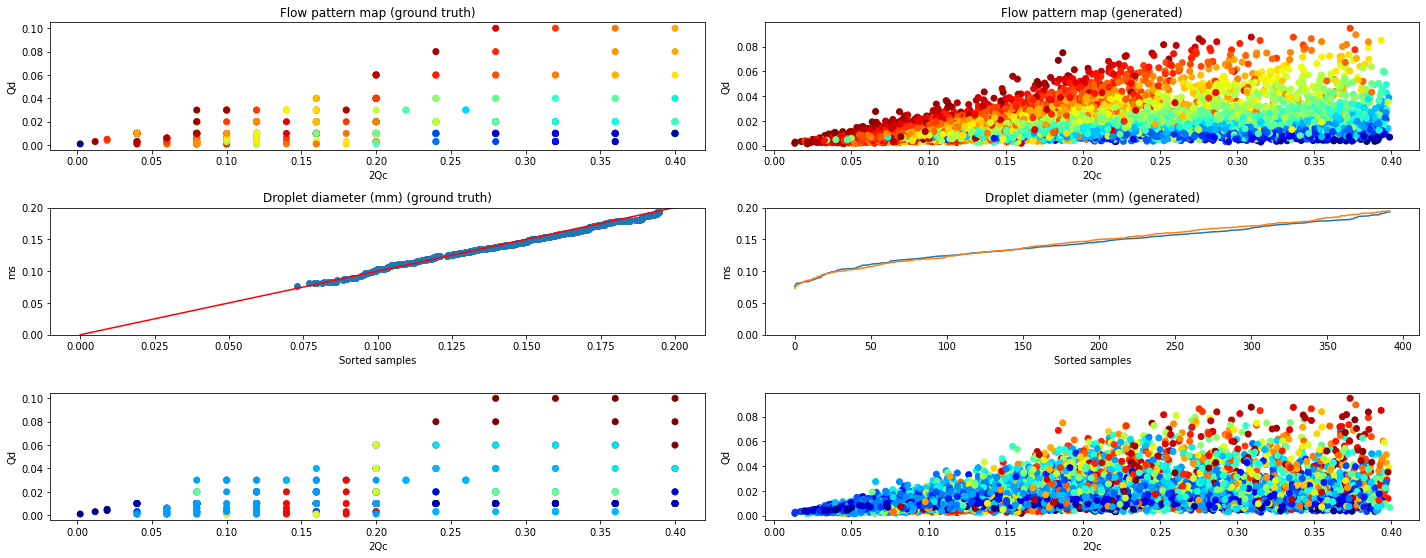

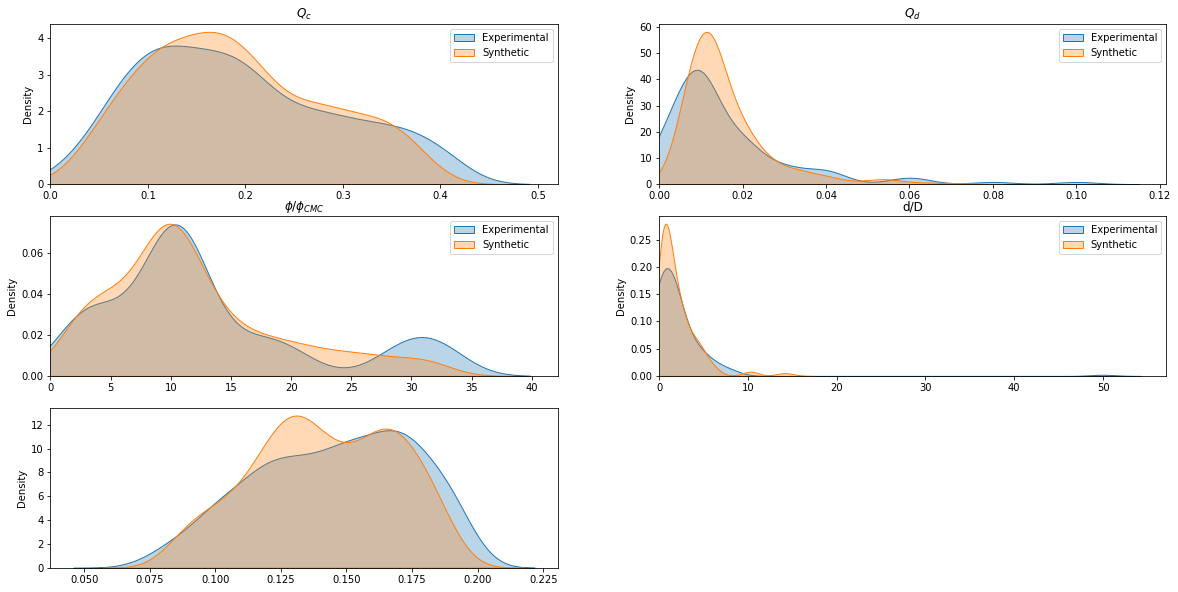

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import time
import random
def plot_latent_space(vae):
  fig = plt.figure(figsize=(20,10))

  def inverseScalerThetis(xscaled, xmin, xmax, min, max):
    scale = (max - min) / (xmax - xmin)
    xInv = (xscaled/scale) - (min/scale) + xmin
    return xInv
  start = time.time()
  size_gen_data = 10000#data.shape[0]
  noise = np.random.normal(size=(size_gen_data, latent_dim))
  predicted_data = vae.decoder.predict(noise)
  predicted_data = inverseScalerThetis(predicted_data, min_ls, max_ls, min, max)
  real_data = inverseScalerThetis(data, min_ls, max_ls, min, max)
  #predicted_data = (predicted_data*stdData) + meanData
  #real_data = (predicted_data*stdData) + meanData
  predicted_data = np.exp(predicted_data)
  real_data = np.exp(real_data)

  predicted_data = predicted_data - 1
  real_data = real_data - 1
  end = time.time() - start
  print(end)
  plt.subplot(4, 2, 1)
  plt.scatter(real_data[:,0], real_data[:, 1], c=real_data[:, -1], cmap='jet')
  #plt.ylim(0, 0.025)
  #plt.xlim(0, 0.4)
  plt.title('Flow pattern map (ground truth)')
  plt.xlabel('2Qc')
  plt.ylabel('Qd')
  plt.subplot(4,2,2)
  plt.scatter(predicted_data[:, 0], predicted_data[:, 1], c=predicted_data[:,-1], cmap='jet')
  #plt.ylim(0,0.025)
  #plt.xlim(0,0.4)
  plt.xlabel('2Qc')
  plt.ylabel('Qd')
  plt.title('Flow pattern map (generated)')
  plt.subplot(4,2,3)
  random_pred_data = random.sample(set(predicted_data[:, -1]), data.shape[0])
  plt.scatter(np.sort(real_data[:,-1]), np.sort(random_pred_data))
  ident = [0.0, 0.2]
  plt.plot(ident,ident, color='r')
  plt.ylim(0,0.2)
  plt.title('Droplet diameter (mm) (ground truth)')
  plt.xlabel('Sorted samples')
  plt.ylabel('ms')
  plt.subplot(4,2,4)
  plt.plot(np.sort(random_pred_data))
  plt.plot(np.sort(real_data[:, -1]))
  MAPE = np.mean(np.abs(np.sort(random_pred_data)- np.sort(real_data[:, -1]))/np.sort(real_data[:, -1]))
  print(MAPE)
  plt.ylim(0,0.2)
  plt.title('Droplet diameter (mm) (generated)')
  plt.xlabel('Sorted samples')
  plt.ylabel('ms')
  plt.subplot(4,2,5)
  plt.scatter(real_data[:, 0], real_data[:, 1], c=real_data[:,2], cmap='jet')
  #plt.ylim(0,0.025)
  #plt.xlim(0,0.4)
  plt.xlabel('2Qc')
  plt.ylabel('Qd')
  plt.subplot(4,2,6)
  plt.scatter(predicted_data[:, 0], predicted_data[:, 1], c=predicted_data[:,2], cmap='jet')
  #plt.ylim(0,0.025)
  #plt.xlim(0,0.4)
  plt.xlabel('2Qc')
  plt.ylabel('Qd')
  plt.tight_layout()
  fig = plt.figure(figsize=(20,10))
  np.save('/content/generated_data_4features', predicted_data)
  #variable_names = ['Qc', 'Qd', '$\gamma$', '$\phi/\phi_{CMC}','Droplet diameter']
  variable_names = ['$Q_{c}$', '$Q_{d}$', '$\phi/\phi_{CMC}$', 'd/D']
  #Mutual Information
  from sklearn.metrics import mutual_info_score
  from sklearn.feature_selection import mutual_info_regression
  from scipy.stats import entropy, ks_2samp
  from scipy.stats import probplot
  import statsmodels.api as sm

  for i in range(5):
    mutual_info = ks_2samp(real_data[:, i], random.sample(set(predicted_data[:, i]), data.shape[0]))
    print(mutual_info)
    plt.subplot(3,2,i+1)
    percs = np.linspace(0,100,data.shape[0])
    a = real_data[:, i]
    b = random.sample(set(predicted_data[:, i]), data.shape[0])
    qn_a = np.percentile(a, percs)
    qn_b = np.percentile(b, percs)
    #plt.plot(qn_a,qn_b, ls="", marker="o")
    #ident = [0.0, np.max(a)]
    #plt.plot(ident,ident, color='r')
    #sm.qqplot(real_data[:, i], random.sample(set(predicted_data[:, i]), data.shape[0]), line='45')
    sns.kdeplot(real_data[:, i], fill=True, alpha = .3, palette="crest")
    sns.kdeplot(random.sample(set(predicted_data[:, i]), data.shape[0]), fill = True, alpha =.3, palette="crest")
    plt.title(variable_names[i])
    #plt.xlabel('Experimental')
    #plt.ylabel('Synthetic')
    plt.legend(['Experimental', 'Synthetic'])
    plt.gca().set_xlim(left=0)
  plt.tight_layout()
plot_latent_space(vae)

#Save the new data for retraining the prediction script

In [ ]:
print(data.shape)

(392, 5)


In [ ]:
  indexSDS = np.load(directory + 'indexSDS.npy')
  indexNS = np.load(directory + 'indexNS.npy')
  indexC12 = np.load(directory + 'indexC12.npy')

  indexC12 = np.delete(indexC12, np.where(indexC12 >= 871))
  def inverseScalerThetis(xscaled, xmin, xmax, min, max):
    scale = (max - min) / (xmax - xmin)
    xInv = (xscaled/scale) - (min/scale) + xmin
    return xInv
  fig = plt.figure(figsize=(20,10))
  plt.subplot(3,2,1)
  plt.title('GT')
  plt.xlim(0, 0.225)
  plt.ylim(0, 0.12)
  real_data = inverseScalerThetis(data, min_ls, max_ls, min, max)
  real_data = np.exp(trainingData)
  real_data = real_data - 1
  plt.scatter(real_data[indexSDS, 1], real_data[indexSDS, 2], c=real_data[indexSDS, 3], cmap = 'jet')  
  hola = vae.encoder.predict(data)
  recon_data = np.exp(inverseScalerThetis(vae.decoder.predict(np.array(vae.encoder.predict(data))[0, :]), min_ls, max_ls, min, max)) - 1
  plt.scatter(recon_data[indexSDS, 1], recon_data[indexSDS, 2], c=recon_data[indexSDS, 3], cmap = 'jet', marker='v')
  
  plt.subplot(3,2,2)
  plt.xlim(0, 0.225)
  plt.ylim(0, 0.12)
  plt.title('Reconstruction')
  hola = vae.encoder.predict(data)
  recon_data = np.exp(inverseScalerThetis(vae.decoder.predict(np.array(vae.encoder.predict(data))[0, :]), min_ls, max_ls, min, max)) - 1
  plt.scatter(recon_data[indexSDS, 1], recon_data[indexSDS, 2], c=recon_data[indexSDS, 3], cmap = 'jet')
  plt.subplot(3,2,3)
  plt.title('GT')
  plt.xlim(0, 0.025)
  plt.ylim(0, 0.12)
  real_data = inverseScalerThetis(data, min_ls, max_ls, min, max)
  real_data = np.exp(trainingData)
  real_data = real_data - 1
  plt.scatter(real_data[indexNS, 1], real_data[indexNS, 2], c=real_data[indexNS, 3], cmap = 'jet')
  plt.subplot(3,2,4)
  plt.xlim(0, 0.225)
  plt.ylim(0, 0.12)
  plt.title('Reconstruction')
  hola = vae.encoder.predict(data)
  recon_data = np.exp(inverseScalerThetis(vae.decoder.predict(np.array(vae.encoder.predict(data))[0, :]), min_ls, max_ls, min, max)) - 1
  plt.scatter(recon_data[indexNS, 1], recon_data[indexNS, 2], c=recon_data[indexNS, 3], cmap = 'jet')
  plt.subplot(3,2,5)
  plt.title('GT')
  plt.xlim(0, 0.225)
  plt.ylim(0, 0.12)
  real_data = inverseScalerThetis(data, min_ls, max_ls, min, max)
  real_data = np.exp(trainingData)
  real_data = real_data - 1
  plt.scatter(real_data[indexC12, 1], real_data[indexC12, 2], c=real_data[indexC12, 3], cmap = 'jet')
  plt.subplot(3,2,6)
  plt.xlim(0, 0.225)
  plt.ylim(0, 0.12)
  plt.title('Reconstruction')
  hola = vae.encoder.predict(data)
  recon_data = np.exp(inverseScalerThetis(vae.decoder.predict(np.array(vae.encoder.predict(data))[0, :]), min_ls, max_ls, min, max)) - 1
  plt.scatter(recon_data[indexC12, 1], recon_data[indexC12, 2], c=recon_data[indexC12, 3], cmap = 'jet')


NameError: ignored